# Ising Model

The Ising model is a mathematical model used to describe statistical physics systems. It was initially proposed by Ernst Ising in 1925 [[1]](#refer-anchor-1) to study phase transition phenomena in magnetic materials with spin interactions.The Ising model finds wide applications in various fields, especially in statistical physics and computer science. Here are some examples of its practical applications:

- Study of phase transitions in magnetic materials: The Ising model is used to investigate phase transition behaviors in magnetic materials, such as the magnetization process and critical temperature of ferromagnetic materials.

- Sociological modeling: The Ising model can be employed to build sociological models, for example, studying the evolution of information spreading, opinion formation, and social behavior in a population.

- Neuroscience: The Ising model can be used to study collective behavior in neural networks, exploring the interactions between neurons and the emergence of collective behavior.

The Ising model defines a probability distribution over samples x, which are taken from the set {1, -1}^p. The distribution function can be expressed as:

$$\mathbb{P}\left(\mathbf{x} \right)=\frac{1}{\Phi(\boldsymbol{\theta}^*)} \exp \left\{\frac{1}{2} \sum_{k, l=1}^{p} \boldsymbol{\theta}^*_{k l} x_{k} x_{l}\right\}.$$

Here, $\boldsymbol{\theta}^*$ is a $p\times p$ matrix, and $\Phi(\boldsymbol{\theta}^*)$ is a normalization constant defined as:

$$\Phi(\boldsymbol{\theta}^*)=\sum\limits_{\mathbf{z}\in \{-1,1\}^p} \exp \left\{\frac{1}{2}\sum_{k, l=1}^{p} \boldsymbol{\theta}^*_{k l} \mathbf{z}_{k} \mathbf{z}_{l}\right\}.$$

The distribution function assigns probabilities to different configurations of spins (samples x), based on the interaction strengths encoded in the θ* matrix. Higher interaction strengths ($\theta^*_{kl}$) between two spins ($x_k$ and $x_l$) contribute to higher probabilities for their aligned orientations.
The normalization constant $\Phi(\boldsymbol{\theta}^*)$ ensures that the probabilities sum up to 1 over all possible configurations of spins, making it a valid probability distribution.
This formulation allows us to model the behavior of physical systems based on the Ising model framework and provides a way to calculate the probabilities of different spin configurations given the interaction strengths represented by the θ* matrix.

We can obtain sparse parameters, θ, by solving the following optimization problem:

\begin{aligned}
& \underset{\boldsymbol{\theta} \in \mathcal{S}_p}{\arg \min } f(\boldsymbol{\theta}):=-\frac{1}{n} \sum_{i=1}^n \log \left(\prod_{k=1}^p \mathbb{P}\left(\mathbf{x}_{i k} \mid \mathbf{x}_{i 1}, \ldots, \mathbf{x}_{i k-1}, \mathbf{x}_{i k+1}, \ldots, \mathbf{x}_{i p}\right)\right), \\
& \text { s.t. }\|\boldsymbol{\theta}\|_0 \leq s .
\end{aligned}

As we have

\begin{aligned}
\mathbb{P}\left(\mathbf{x}_{i k} \mid \mathbf{x}_{i 1}, \ldots, \mathbf{x}_{i k-1}, \mathbf{x}_{i k+1}, \ldots, \mathbf{x}_{i p}\right)=&
\frac{\exp\left(\frac12 \sum_{l,m=1}^p\theta_{lm}x_{il}x_{im}\right)}{\exp\left(\frac12 \sum_{l,m=1}^p\theta_{lm}x_{il}x_{im}\right)+\exp\left(\frac12\left(\theta_{kk}x_{ik}^2-2\sum_{l\neq k}\theta_{kl}x_{ik}x_{il}+\sum_{l,m\neq k}\theta_{lm}x_{il}x_{im}\right)\right)}\\
=& \frac1{1+\exp\left(-2\sum_{l\neq k}\theta_{kl}x_{ik}x_{il}\right)}\\
=& \frac1{1+\exp\left(-2x_{ik}\sum_{l\neq k}\theta_{kl}x_{il}\right)}.
\end{aligned}

The function $f(\boldsymbol{\theta})$ can be written in the following form, using the given expression for the conditional probability:

\begin{aligned}
f(\boldsymbol{\theta}) = -\frac{1}{n} \sum_{i=1}^n\sum_{k=1}^p\log \left(\frac{1}{1+\exp\left(-2x_{ik}\sum_{l\neq k}\theta_{kl}x_{il}\right)}\right).
\end{aligned}

To solve this optimization problem, let's consider using the `scope` package.

In [1]:
from scope import GraspSolver, ScopeSolver
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import itertools

We set the sample size n = 250, dimension p = 10, and support set size s = 10. We then choose parameters θ such that it represents a sparse symmetric matrix, and each entry has an equal probability of being either 1 or -1.

In [2]:
def generate_theta(p, s):
    
    # Generate an array of random values
    values = np.random.choice([-1, 1], size=s)
    
    # Initialize S matrix with zeros
    S = np.zeros((p, p))
    indices = np.triu_indices(p, k=1)
    
    # Randomly select s elements from the upper triangle to set to values
    total_elements = len(indices[0])
    selected_indices = np.random.choice(total_elements, size=s, replace=False)
    S[indices[0][selected_indices], indices[1][selected_indices]] = values
    
    # Compute theta as the transpose of S plus S
    theta = S.T + S

    return theta

p = 10
s = 10
n = 250

np.random.seed(0)
theta = generate_theta(p, s)

Below, we define a class called `IsingData`. Its `.table` is a $2^p\times p$ matrix, with the row vectors form the set $\{1,-1\}^p$. The `.freq` attribute stores the frequency of occurrence for each element in the set $\{1,-1\}^p$ during simulation. Then, we construct a sample that belongs to the `IsingData` class.

In [3]:
class IsingData:
    def __init__(self, data):
        self.n = data.shape[0]
        self.p = data.shape[1] - 1
        self.table = data[:, 1:]
        self.freq = data[:, 0]

        self.index_translator = np.zeros(shape=(self.p, self.p), dtype=np.int32)
        idx = 0
        for i in range(self.p):
            for j in range(i + 1, self.p):
                self.index_translator[i, j] = idx
                self.index_translator[j, i] = idx
                idx += 1
                
def generate_samples(theta, n):
    p = theta.shape[0]
    z_values = np.array(np.meshgrid(*[(-1, 1)] * p)).T.reshape(-1, p)
    exponent = np.exp(0.5 * np.sum(np.multiply(np.matmul(z_values, theta), z_values), axis=1))
    normalization = np.sum(exponent)
    probabilities = exponent / normalization

    sampled_indices = np.random.choice(range(2 ** p), size = n, p = probabilities)
    counts = np.zeros(2 ** p)
    for idx in sampled_indices:
        counts[idx] += 1
    
    result = np.zeros((2 ** p, p + 1))
    result[:, 0] = counts
    result[:, 1:] = z_values
        
    return IsingData(result)

data = generate_samples(theta, n)

Below, we define the loss function for the Ising model.

In [4]:
def loss_jax(params, data):
    tmp = -2.0 * np.matmul(data.table[:, :, np.newaxis], data.table[:, np.newaxis, :])
    tmp[:, np.arange(data.p), np.arange(data.p)] = 0.0
    params_mat = params[data.index_translator]

    return jnp.dot(
        data.freq,
        jnp.sum(
            jnp.logaddexp(
                jnp.sum(
                    jnp.multiply(
                        params_mat[:, :],
                        tmp,
                    ),
                    axis=2,
                ),
                0,
            ),
            axis=1,
        ),
    )

Below, we use the `ScopeSolver` and `GraspSolver` from the `scope` package to minimize the loss function under the $L_0$ constraint. The `GraspSolver` employs the Gradient Support Pursuit (GraSP) optimization method [[2]](#refer-anchor-2).

In [5]:
solver = ScopeSolver(
    dimensionality=int(p * (p - 1) / 2),
    sparsity=np.count_nonzero(theta[np.triu_indices(p)]),
)  

solver.solve(
    loss_jax,
    data,
    init_params=jnp.zeros(int(p * (p - 1) / 2)),
)

theta_scope = np.zeros((p, p))
theta_scope[np.triu_indices(p, k=1)] = solver.params
theta_scope = np.where(
    theta_scope, theta_scope, theta_scope.T
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
solver = GraspSolver(
    dimensionality=int(p * (p - 1) / 2),
    sparsity=np.count_nonzero(theta[np.triu_indices(p)]),
)  

solver.solve(
    loss_jax,
    data,
    init_params=jnp.zeros(int(p * (p - 1) / 2)),
)

theta_grasp = np.zeros((p, p))
theta_grasp[np.triu_indices(p, k=1)] = solver.params
theta_grasp = np.where(
    theta_grasp, theta_grasp, theta_grasp.T
)

Below, we calculate the difference between the estimated values and the actual values of the Scope and Grasp estimators in terms of the Frobenius norm. We then display their matrix heatmaps.

In [7]:
print('Scope: ', np.linalg.norm(theta - theta_scope, ord='fro'))
print('Grasp: ', np.linalg.norm(theta - theta_grasp, ord='fro'))

Scope:  0.8640962324367055
Grasp:  6.974435943071625


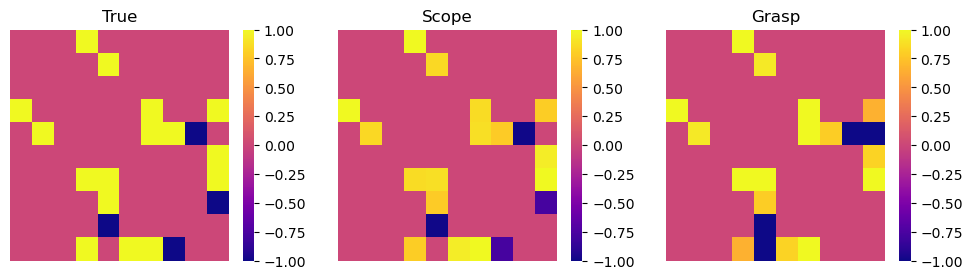

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

cmap = cm.plasma

sns.heatmap(theta, vmin=-1, vmax=1, cmap=cmap, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('True')

sns.heatmap(theta_scope, vmin=-1, vmax=1, cmap=cmap, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Scope')

sns.heatmap(theta_grasp, vmin=-1, vmax=1, cmap=cmap, ax=axes[2])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Grasp')

plt.show()

### Reference

<div id="refer-anchor-1"></div>

- [1] Ising, E. (1925). Beitrag zur Theorie des Ferromagnetismus. Z. Physik 31, 253–258.  https://doi.org/10.1007/BF02980577

<div id="refer-anchor-2"></div>

- [2] Bahmani, S., Raj, B., & Boufounos, P. T. (2013). Greedy sparsity-constrained optimization. The Journal of Machine Learning Research, 14(1), 807-841.